In [2]:
import spacy

In [3]:
!python -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 43.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
# imports

import pandas as pd
import numpy as np
import preprocess_kgptalkie as ps # special NLP cleaning module, found at: https://github.com/laxmimerit/preprocess_kgptalkie
import re
import contractions
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import string
import gzip
import shutil

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

In [6]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bosea\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bosea\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
# extract .gz data file
with gzip.open('../data/raw/All_Beauty.json.gz', 'rb') as f_in:
    with open('../data/raw/All_Beauty.json', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

### Exploratory Data Analysis

In [10]:
# load data

beauty_data = pd.read_json("../data/raw/All_Beauty.json", lines = True)

In [11]:
# check the shape of our data 
beauty_data.shape

(371345, 12)

We note that we have 371,345 instances and 12 feature variables. 

In [7]:
# preview data

beauty_data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN
2,4,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN
3,5,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,NaN,NaN
4,5,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,NaN,NaN


From previewing the data, these are the columns/features of interest for us: 
- "overall": This is the score of the review, between 1 and 5, with 1 being the lowest/poorest score and 5 being the highest/best score. 
- "reviewText": This is the text body of the review. 
- "summary": This is the text title of the review. 

In [8]:
# create new df containing only columns of interest, then rename columns using more meaningful descriptors
beauty_data_less = beauty_data[["overall", "reviewText", "summary"]]
beauty_data_less.columns = ["rating", "review", "title"]

In [9]:
# check the (normalized) distribution of ratings
beauty_data_less["rating"].value_counts(normalize=True)

5    0.618156
4    0.141882
1    0.105726
3    0.079589
2    0.054647
Name: rating, dtype: float64

<AxesSubplot:xlabel='rating', ylabel='Count'>

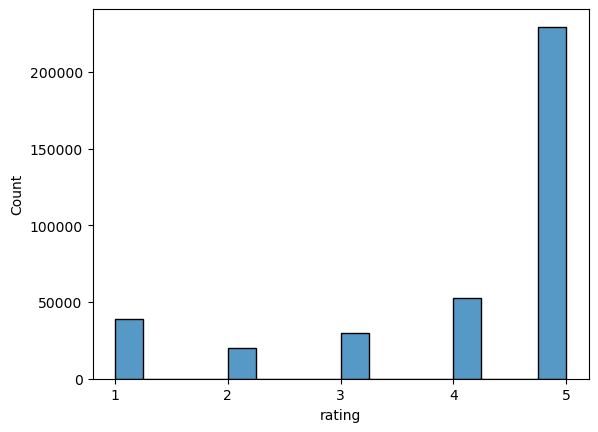

In [10]:
# show histogram of the ratings
from matplotlib.pyplot import xticks


g = sns.histplot(beauty_data_less["rating"], binwidth=0.25)
g.set_xticks(range(1, 6))
g.set_xticklabels(['1','2','3','4','5'])
g

We note that the dataset is imbalanced, with most of the scores skewing towards a rating of 5.

In [11]:
# check for missing data
beauty_data_less.isna().sum()

rating      0
review    399
title     206
dtype: int64

We note that there are 399 reviews with missing review text, and 206 reviews with a missing title. Since the title is less important than the review body, it makes sense to drop all reviews that have missing review text, but retain the ones with a missing title. In the pre-processing steps outlined in the next section, we will combine the title and the review text into a single feature. 

### Pre-Processing
General tasks:
- combine "title" and "review" into a single column containing all text (concatenate and delimit using a space)
- remove instances with no review text (remove missing data)
- create a smaller subset of the dataset to try out NLP Tasks outlined below, before applying to full dataset
    - Note: this step was performed and then removed from this notebook to save space and time

NLP Tasks:
- convert all text to lower-case, replace backslash with nothing (''), and replace underscore with a space
- remove punctuation
- remove stopwords
- expand contractions

In [12]:
# drop instances that have missing review text
print(beauty_data_less.isna().sum()) # check number of missing data instances before dropping 

# drop instances missing "review" data
beauty_data_less.dropna(subset = ["review"], inplace = True)

beauty_data_less.isna().sum() # check number of missing data instances after dropping

rating      0
review    399
title     206
dtype: int64


C:\Users\bosea\AppData\Local\Temp\ipykernel_10420\415711606.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beauty_data_less.dropna(subset = ["review"], inplace = True)


rating      0
review      0
title     190
dtype: int64

In [13]:
# combine "title" and "review" into a single column containing all text
beauty_data_less["full_review"] = beauty_data_less[["title", "review"]].astype(str).apply(" ".join, axis=1)

C:\Users\bosea\AppData\Local\Temp\ipykernel_10420\3614466120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beauty_data_less["full_review"] = beauty_data_less[["title", "review"]].astype(str).apply(" ".join, axis=1)


In [14]:
# now that we have the single column with full review text, we can drop the individual "review" and "title" columns
beauty_data_less.drop(labels = ['review', 'title'], inplace = True, axis = 'columns')

C:\Users\bosea\AppData\Local\Temp\ipykernel_10420\1122389653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beauty_data_less.drop(labels = ['review', 'title'], inplace = True, axis = 'columns')


In [15]:
# preview new feature column "full_review"
beauty_data_less.head(5)

,rating,full_review
0,1,One Star great
1,4,... to reading about the Negro Baseball and th...
2,4,"Worth the Read This book was very informative,..."
3,5,Good Read I am already a baseball fan and knew...
4,5,"More than facts, a good story read! This was a..."


In [16]:
# re-check shape of the dataset
beauty_data_less.shape

(370946, 2)

#### Feature Engineering
- Clean reviews (several steps, see cleaning function below)
- Tokenize reviews
- Convert review scores to negative (1-2), neutral (3), or positive (4-5)
- Lemmatize tokenized reviews
- Form lemmatized sentences

In [17]:
# define a function to clean review text. here, we are using a custom NLP pre-processing package called "preprocess_kgptalkie", found at: https://github.com/laxmimerit/preprocess_kgptalkie

def get_clean(x: str) -> str:
    '''
    Cleanse a string by converting all text to lower-case, expanding contractions, removing stop words, 
    remove emails, URLs, and HTML tags, remove accented, special, and repeated characters

    Parameters
    ----------
    x : str
        A single string of words (reviews).

    Returns
    -------
    x : str
        A cleansed document string.
    '''
    x = str(x).lower().replace('\\', '').replace('_', ' ') # lower-case all words, replace \ with nothing, replace _ with a space
    x = ps.cont_exp(x) # expand contractions
    x = ps.remove_emails(x) # remove emails
    x = ps.remove_urls(x) # remove URLs
    x = ps.remove_html_tags(x) # remove HTML tags
    x = ps.remove_accented_chars(x) # remove accented characters
    x = ps.remove_special_chars(x) # remove special characters
    x = re.sub("(.)\\1{2,}", "\\1", x) # remove multiple repeated characters
    x = ps.remove_stopwords(x) # remove stop words
    return x

In [18]:
# credit to Mihail Eric for this function
stopwords = stopwords.words('english')
def get_top_ngrams(corpus, ngram_len: int=1, num: int=None) -> list:
    vec = CountVectorizer(ngram_range=(ngram_len, ngram_len), stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:num]

### Applying all pre-processing steps above to the full dataset

#### WARNING: This may take several minutes (upwards of 10) to run depending on your machine

In [19]:
# clean the "full_review" column by applying above function to it
beauty_data_less["full_review_clean"] = beauty_data_less["full_review"].apply(lambda x: get_clean(x))

c:\Users\bosea\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\bosea\AppData\Local\Temp\ipykernel_10420\3973091898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beauty_data_less["full_review_clean"] = beauty_data_less["full_review"].apply(lambda x: get_clean(x))


In [25]:
# next we 'tokenize' each review-- create a list of words for each full clean review
beauty_data_less["clean_tokenized_review"] = beauty_data_less["full_review_clean"].apply(lambda review: [token for token in review.split()])

# # next we add a column "n_tokens" which is simply a count of how many tokens are each review
# beauty_data_less["n_tokens"] = beauty_data_less["clean_tokenized_review"].apply(lambda tokens: len(tokens))

# add column to convert review scores to "negative", "neutral", or positive
beauty_data_less["target"] = beauty_data_less["rating"].apply(lambda rating: "negative" if rating <= 2 else "neutral" if rating == 3  else "positive")

# preview beauty_data_less
beauty_data_less.head()

C:\Users\bosea\AppData\Local\Temp\ipykernel_10420\4107303660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beauty_data_less["clean_tokenized_review"] = beauty_data_less["full_review_clean"].apply(lambda review: [token for token in review.split()])
C:\Users\bosea\AppData\Local\Temp\ipykernel_10420\4107303660.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beauty_data_less["target"] = beauty_data_less["rating"].apply(lambda rating: "negative" if rating <= 2 else "neutral" if rating == 3  else "posit

,rating,full_review,full_review_clean,clean_tokenized_review,target,lemma,lemma_sent
0,1,One Star great,star great,"[star, great]",negative,"[star, great]",star great
1,4,... to reading about the Negro Baseball and th...,reading negro baseball great addition library ...,"[reading, negro, baseball, great, addition, li...",positive,"[read, negro, baseball, great, addition, libra...",read negro baseball great addition library lib...
2,4,"Worth the Read This book was very informative,...",worth read book informative covering aspects game,"[worth, read, book, informative, covering, asp...",positive,"[worth, read, book, informative, cover, aspect...",worth read book informative cover aspects game
3,5,Good Read I am already a baseball fan and knew...,good read baseball fan knew bit negro leagues ...,"[good, read, baseball, fan, knew, bit, negro, ...",positive,"[good, read, baseball, fan, know, bite, negro,...",good read baseball fan know bite negro league ...
4,5,"More than facts, a good story read! This was a...",facts good story read good story black leagues...,"[facts, good, story, read, good, story, black,...",positive,"[facts, good, story, read, good, story, black,...",facts good story read good story black league ...


positive    0.759938
negative    0.160428
neutral     0.079634
Name: target, dtype: float64


<AxesSubplot:xlabel='target', ylabel='Count'>

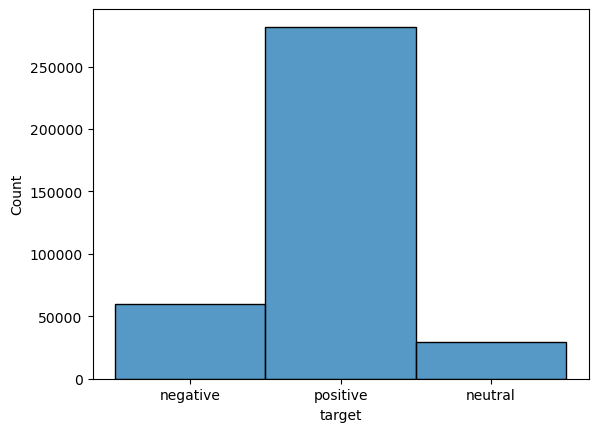

In [27]:
# look at distribution of new column "target"
print(beauty_data_less["target"].value_counts(normalize=True))

# histogram
g = sns.histplot(beauty_data_less["target"], binwidth=0.25)
g.set_xticks(range(0, 3))
g.set_xticklabels(['negative','positive','neutral'])
g

In [28]:
# next we lemmatize each review; essentially getting the "root" form of each word which will help us reduce the complexity for training our models

wn_lemmatizer = WordNetLemmatizer()

beauty_data_less['lemma'] = beauty_data_less['clean_tokenized_review'].apply(lambda text: [ wn_lemmatizer.lemmatize(word, pos='v') for word in text ])
beauty_data_less['lemma_sent'] = beauty_data_less['lemma'].apply(lambda r: ' '.join(r))
beauty_data_less.head(5)

C:\Users\bosea\AppData\Local\Temp\ipykernel_10420\2627958919.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beauty_data_less['lemma'] = beauty_data_less['clean_tokenized_review'].apply(lambda text: [ wn_lemmatizer.lemmatize(word, pos='v') for word in text ])
C:\Users\bosea\AppData\Local\Temp\ipykernel_10420\2627958919.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beauty_data_less['lemma_sent'] = beauty_data_less['lemma'].apply(lambda r: ' '.join(r))


,rating,full_review,full_review_clean,clean_tokenized_review,target,lemma,lemma_sent
0,1,One Star great,star great,"[star, great]",negative,"[star, great]",star great
1,4,... to reading about the Negro Baseball and th...,reading negro baseball great addition library ...,"[reading, negro, baseball, great, addition, li...",positive,"[read, negro, baseball, great, addition, libra...",read negro baseball great addition library lib...
2,4,"Worth the Read This book was very informative,...",worth read book informative covering aspects game,"[worth, read, book, informative, covering, asp...",positive,"[worth, read, book, informative, cover, aspect...",worth read book informative cover aspects game
3,5,Good Read I am already a baseball fan and knew...,good read baseball fan knew bit negro leagues ...,"[good, read, baseball, fan, knew, bit, negro, ...",positive,"[good, read, baseball, fan, know, bite, negro,...",good read baseball fan know bite negro league ...
4,5,"More than facts, a good story read! This was a...",facts good story read good story black leagues...,"[facts, good, story, read, good, story, black,...",positive,"[facts, good, story, read, good, story, black,...",facts good story read good story black league ...


### Visualization of Top 10 n-grams

In [29]:
# set up top 10 n-grams (uni-, bi-, and tri- ) for each 'target' review: negative, neutral, and positive
 
lemma_neg = beauty_data_less[beauty_data_less['target'] == 'negative']['lemma_sent']
lemma_neu = beauty_data_less[beauty_data_less['target'] == 'neutral']['lemma_sent']
lemma_pos = beauty_data_less[beauty_data_less['target'] == 'positive']['lemma_sent']

# set up top 10 unigrams for each target
top_unigrams_neg = get_top_ngrams(lemma_neg, 1, 10)
top_unigrams_neu = get_top_ngrams(lemma_neu, 1, 10)
top_unigrams_pos = get_top_ngrams(lemma_pos, 1, 10)

# set up top 10 bigrams for each review score
top_bigrams_neg = get_top_ngrams(lemma_neg, 2, 10)
top_bigrams_neu = get_top_ngrams(lemma_neu, 2, 10)
top_bigrams_pos = get_top_ngrams(lemma_pos, 2, 10)

# set up top 10 trigrams for each review score
top_trigrams_neg = get_top_ngrams(lemma_neg, 3, 10)
top_trigrams_neu = get_top_ngrams(lemma_neu, 3, 10)
top_trigrams_pos = get_top_ngrams(lemma_pos, 3, 10)

In [30]:
# define plotting parameters

TITLE_FONTSIZE = 16
LABEL_FONTSIZE = 14
WIDE_LABEL_FONTSIZE = 11
SQUARE_PLOT_DIMENSIONS = (8, 8)
WIDE_PLOT_DIMENSIONS = (16, 8)
ROTATION_DEG = 40

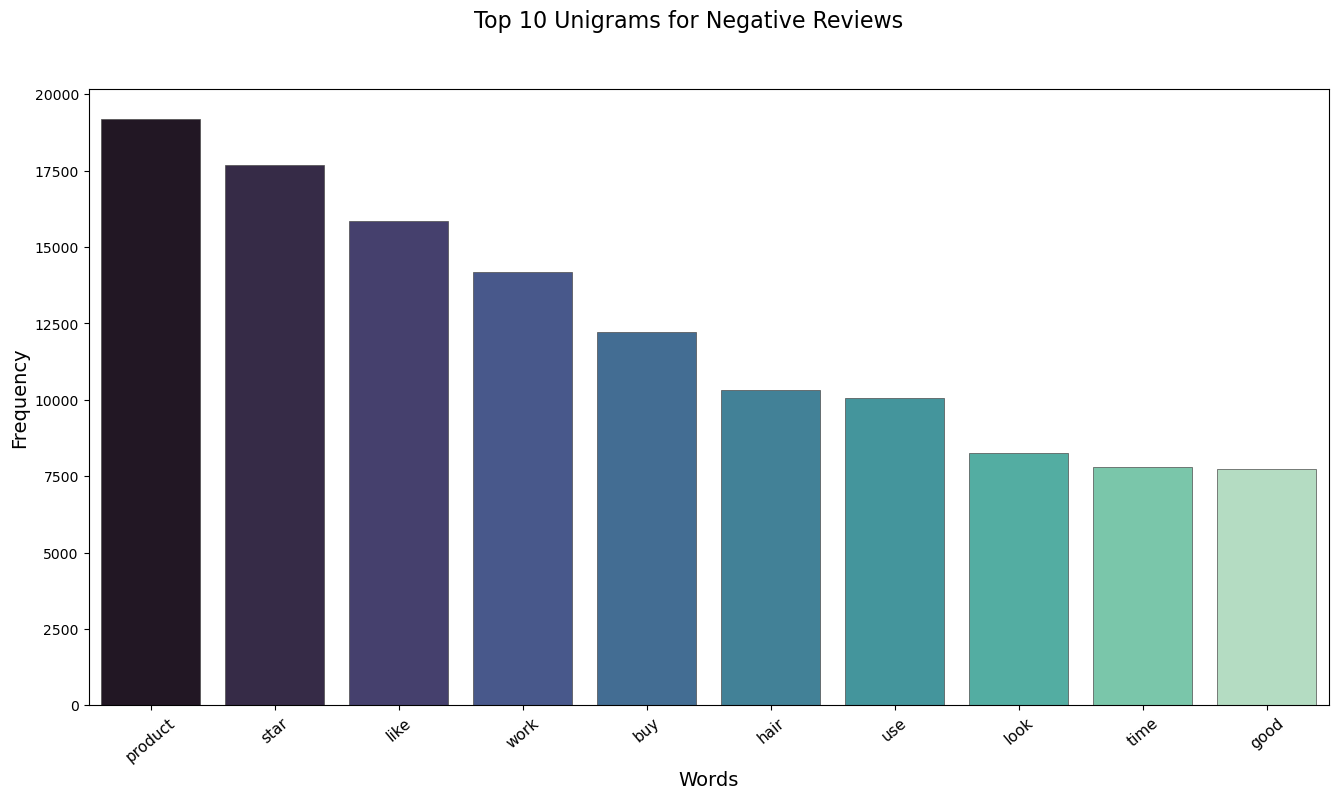

In [48]:
# plot top unigrams for negative reviews

x, y = zip(*top_unigrams_neg)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Unigrams for Negative Reviews', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/unigram_negative_top10.png')
plt.show()

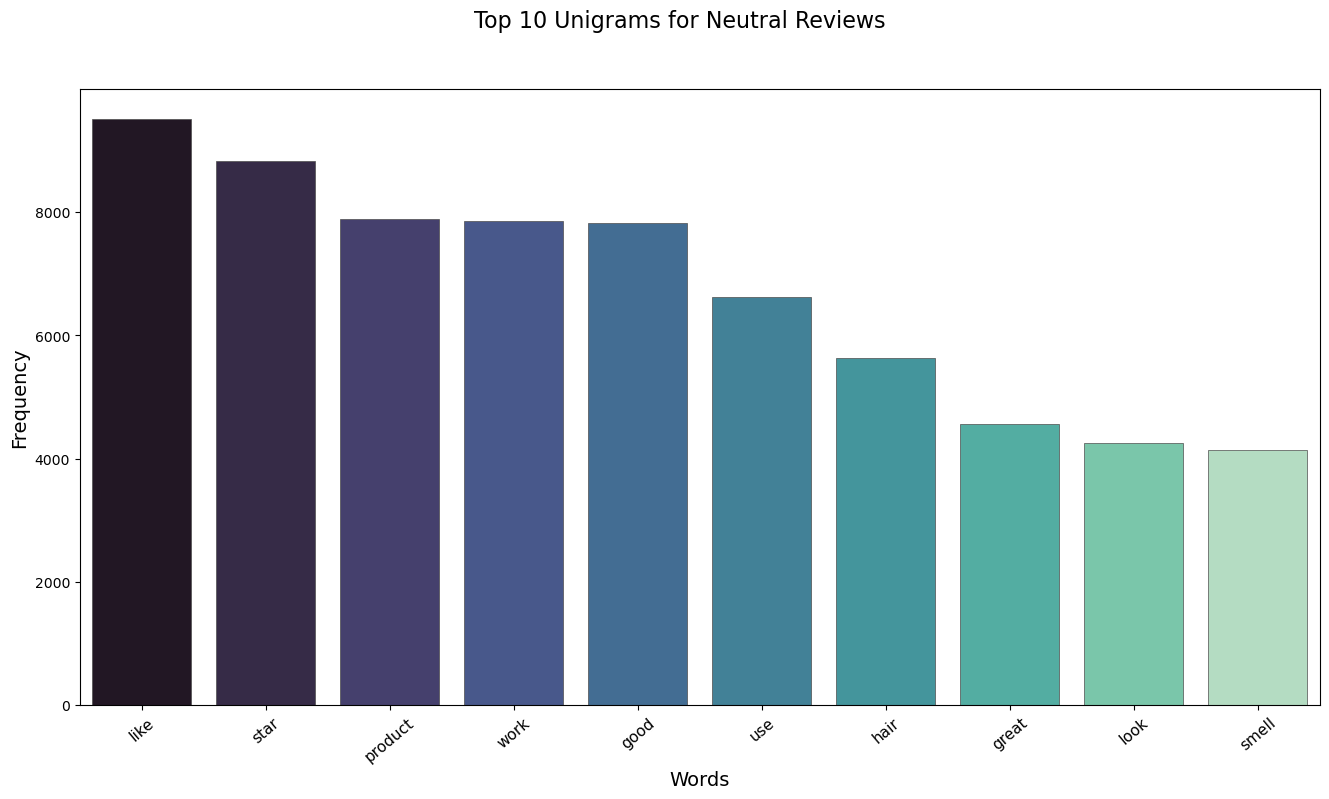

In [49]:
# plot top unigrams for neutral reviews

x, y = zip(*top_unigrams_neu)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Unigrams for Neutral Reviews', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/unigram_neutral_top10.png')
plt.show()

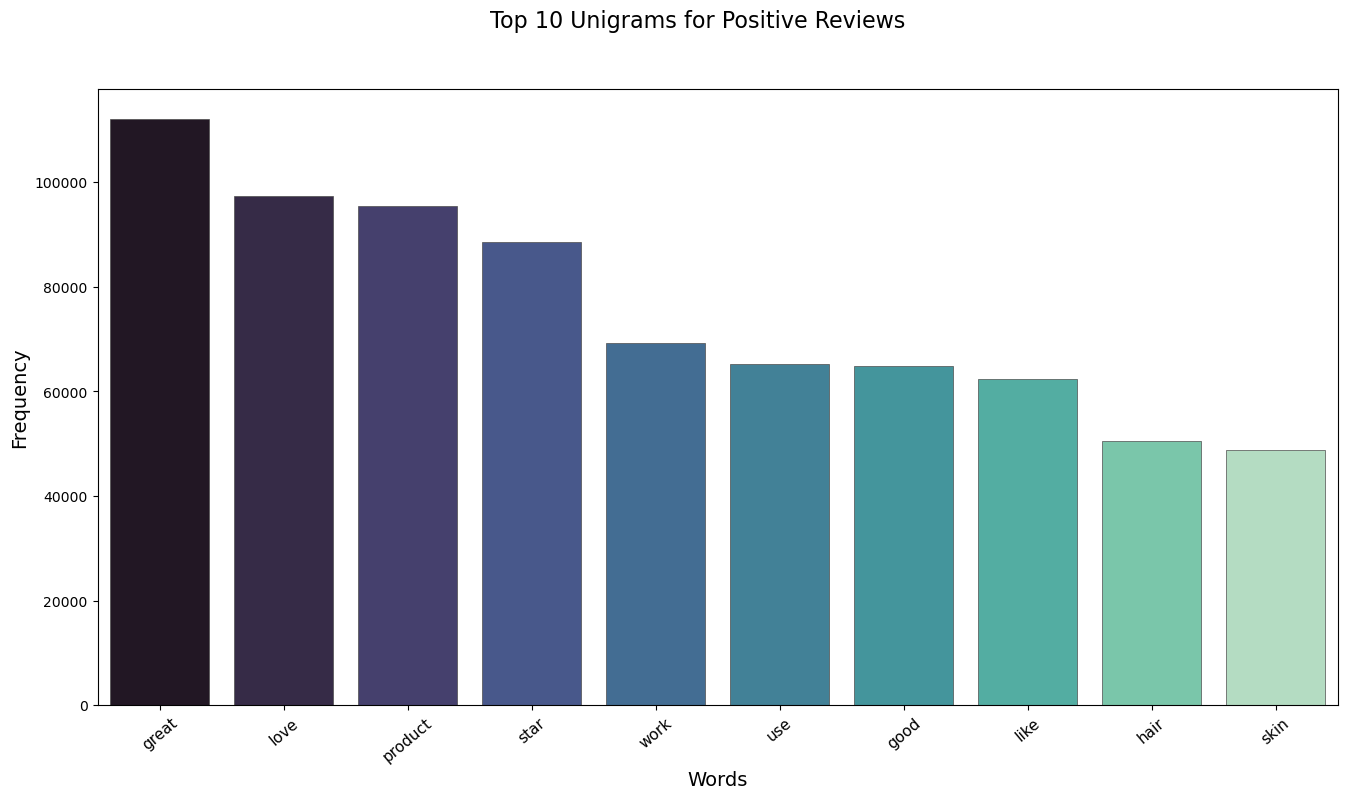

In [58]:
# plot top unigrams for positive reviews

x, y = zip(*top_unigrams_pos)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Unigrams for Positive Reviews', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/unigram_positive_top10.png')
plt.show()

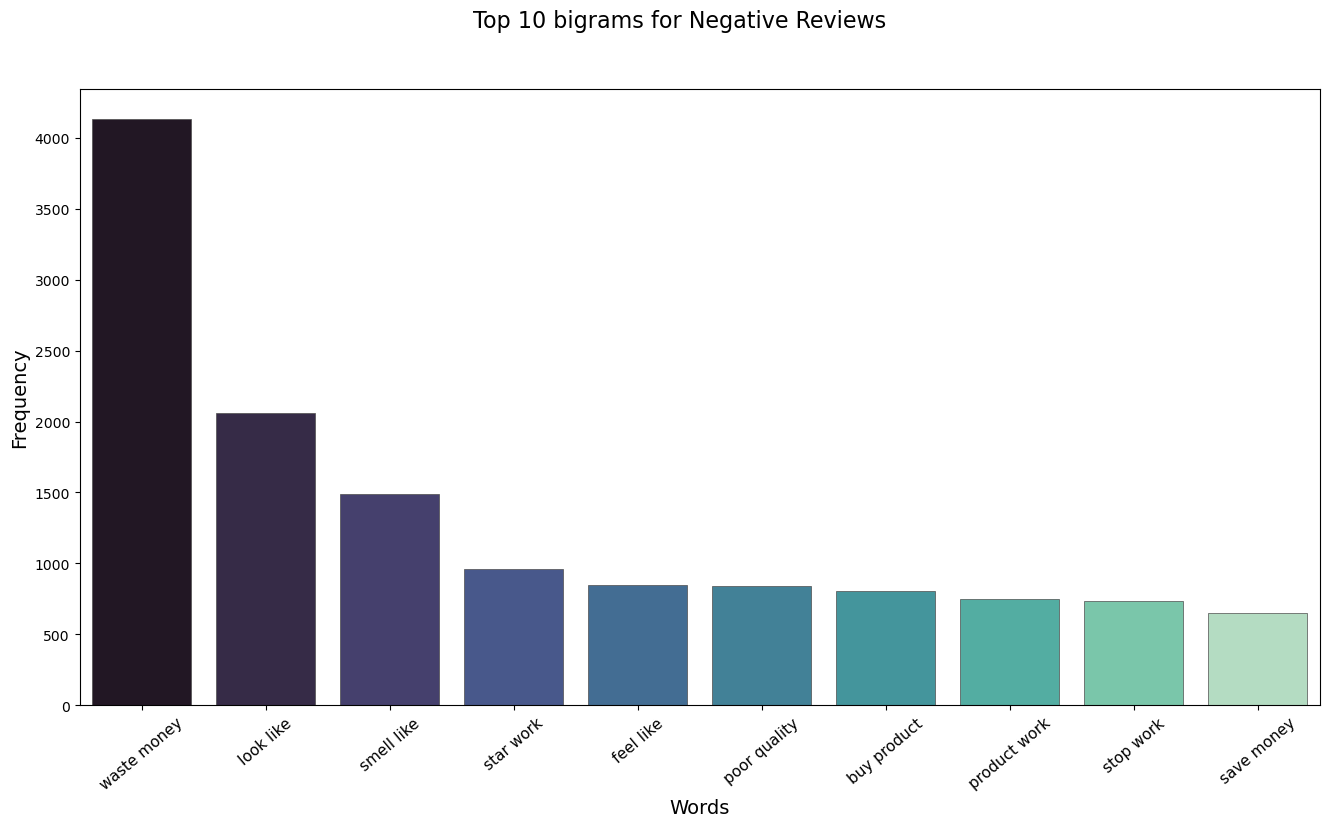

In [53]:
# plot top bigrams for negative reviews

x, y = zip(*top_bigrams_neg)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 bigrams for Negative Reviews', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/bigram_negative_top10.png')
plt.show()

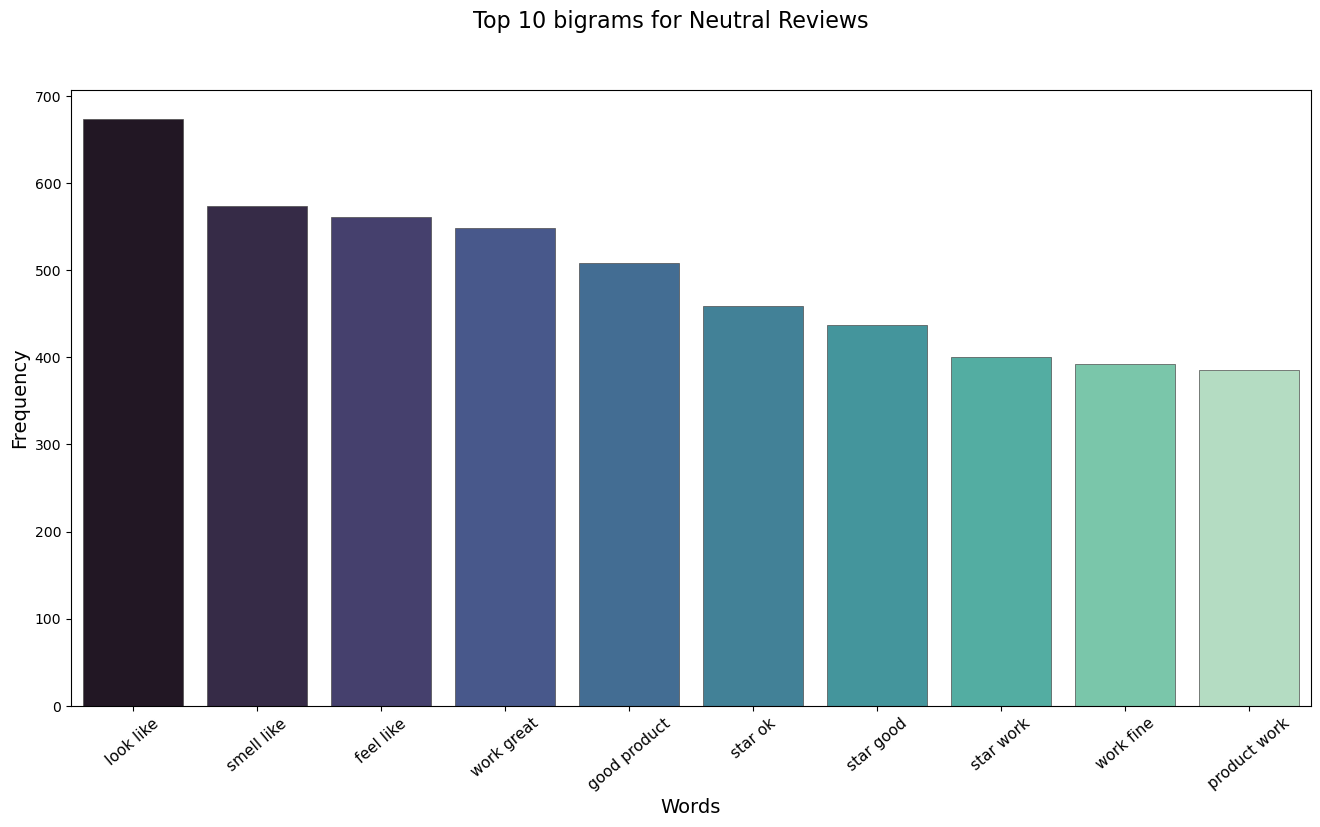

In [32]:
# plot top bigrams for neutral reviews

x, y = zip(*top_bigrams_neu)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 bigrams for Neutral Reviews', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/bigram_neutral_top10.png', bbox_inches="tight")
plt.show()

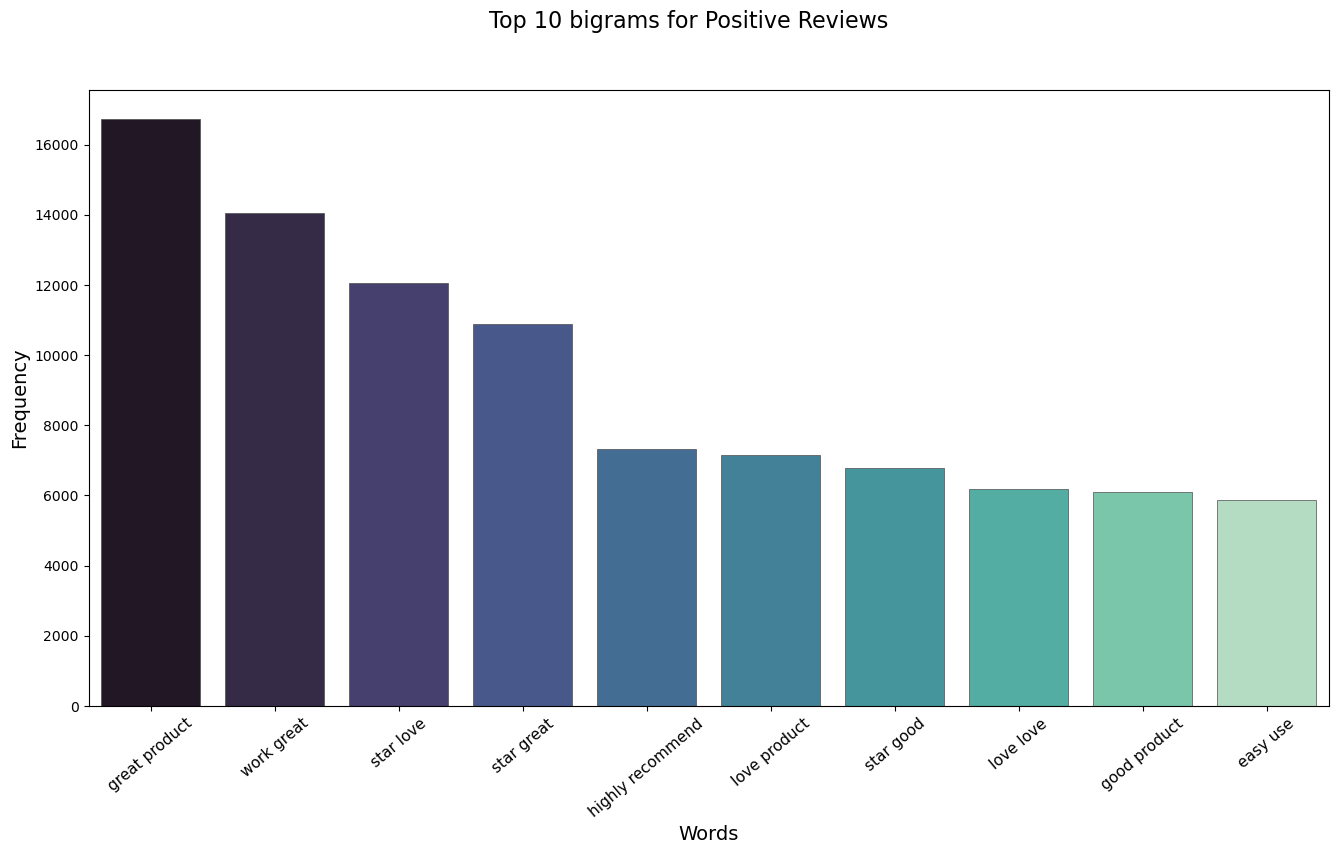

In [31]:
# plot top bigrams for positive reviews

x, y = zip(*top_bigrams_pos)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 bigrams for Positive Reviews', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/bigram_positive_top10.png', bbox_inches="tight")
plt.show()

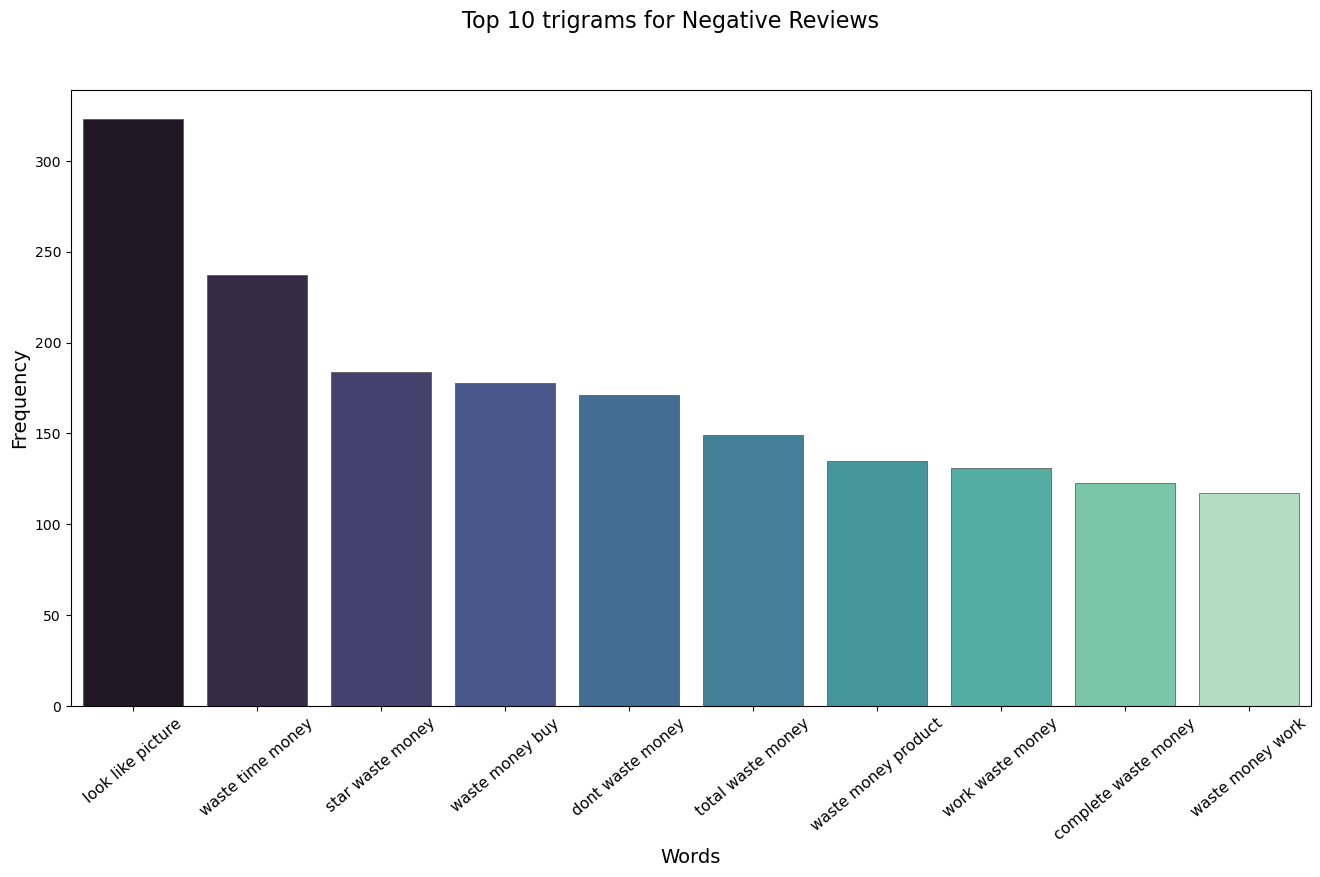

In [33]:
# plot top trigrams for negative reviews

x, y = zip(*top_trigrams_neg)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 trigrams for Negative Reviews', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/trigram_negative_top10.png', bbox_inches="tight")
plt.show()

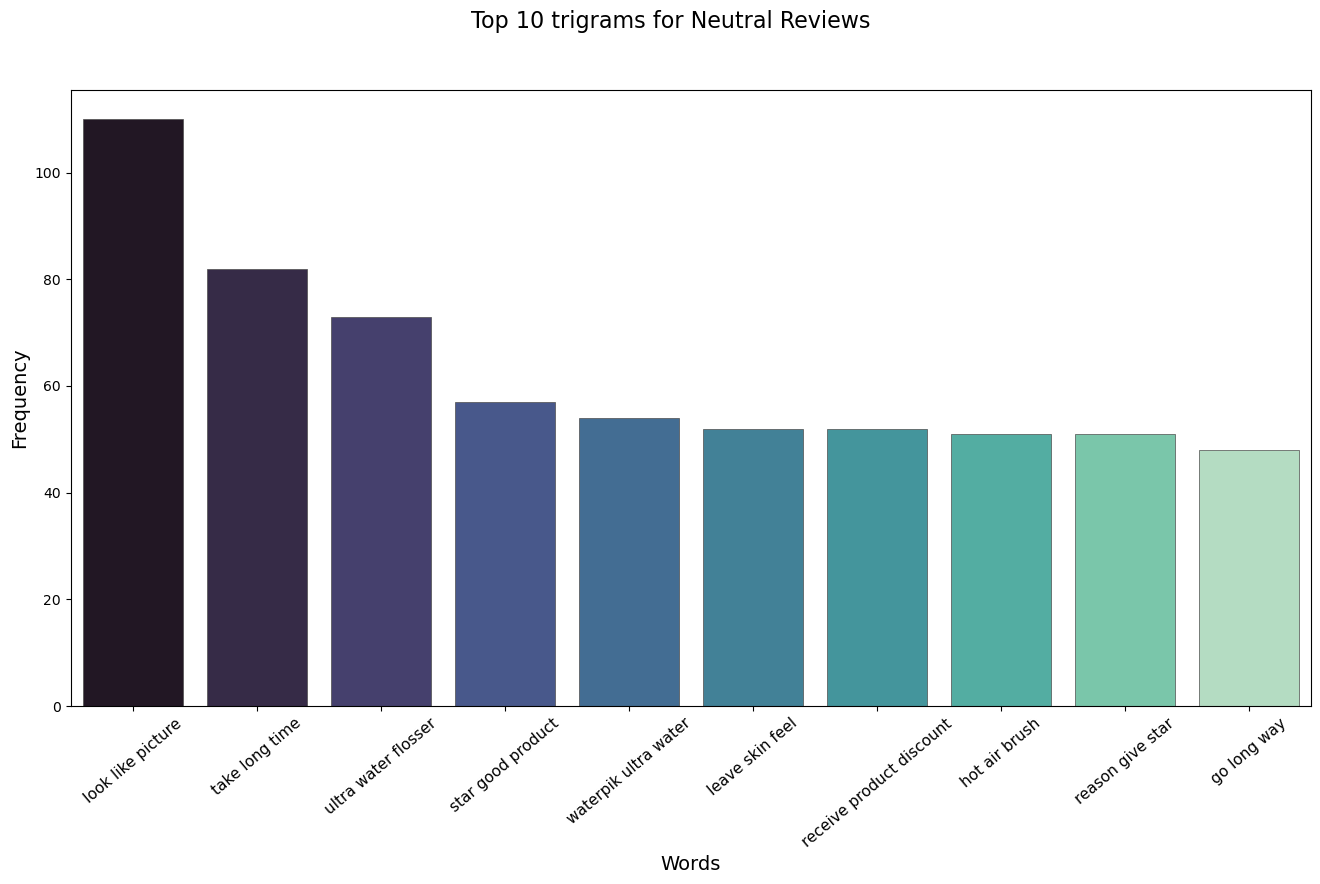

In [34]:
# plot top trigrams for neutral reviews

x, y = zip(*top_trigrams_neu)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 trigrams for Neutral Reviews', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/trigram_neutral_top10.png', bbox_inches="tight")
plt.show()

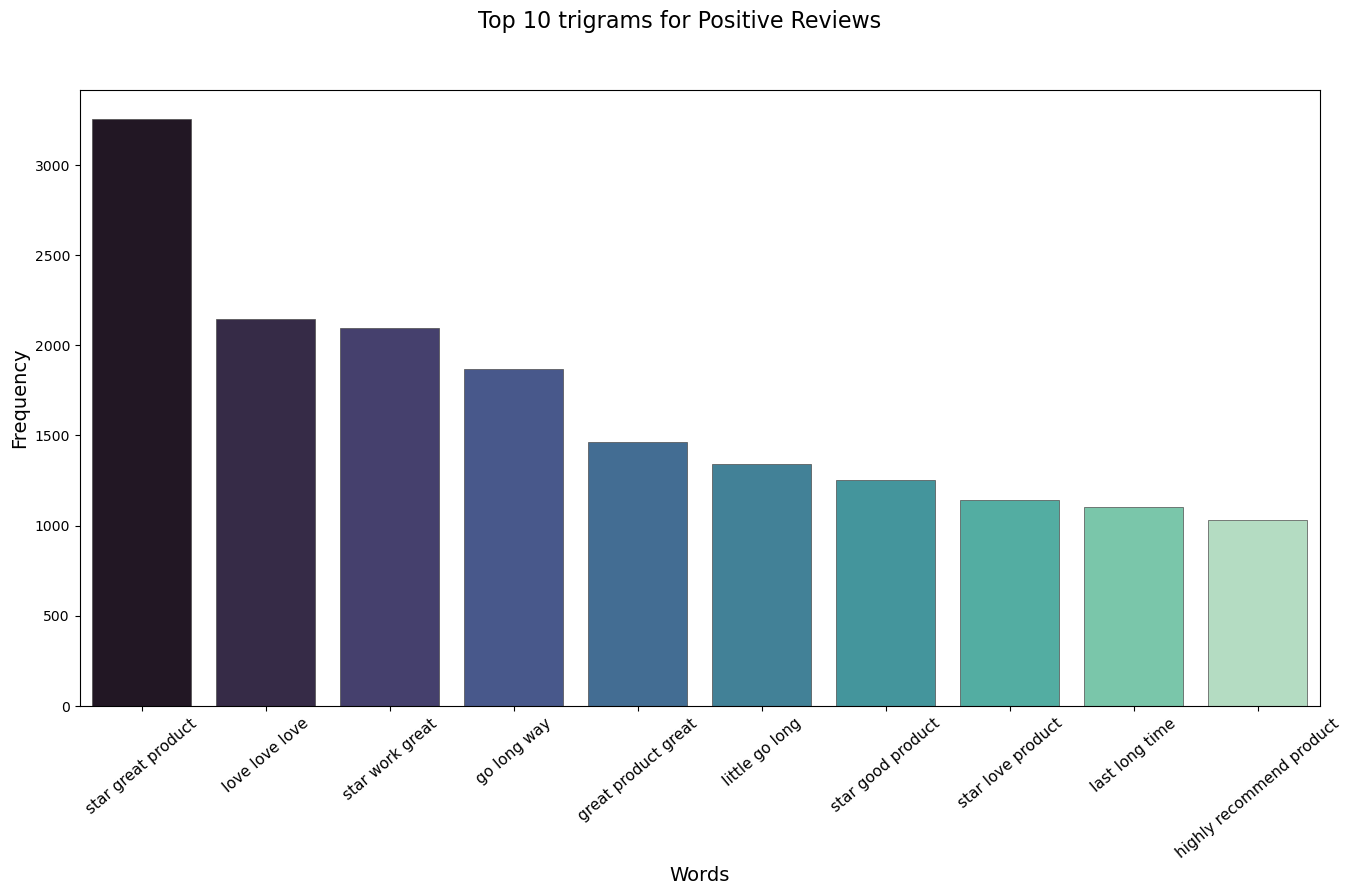

In [35]:
# plot top trigrams for positive reviews

x, y = zip(*top_trigrams_pos)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 trigrams for Positive Reviews', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/trigram_positive_top10.png', bbox_inches="tight")
plt.show()

In [27]:
# set up top 10 n-grams (uni-, bi-, and tri- ) for each review score from 1 to 5
 
lemma_1 = beauty_data_less[beauty_data_less['rating'] == 1]['lemma_sent']
lemma_2 = beauty_data_less[beauty_data_less['rating'] == 2]['lemma_sent']
lemma_3 = beauty_data_less[beauty_data_less['rating'] == 3]['lemma_sent']
lemma_4 = beauty_data_less[beauty_data_less['rating'] == 4]['lemma_sent']
lemma_5 = beauty_data_less[beauty_data_less['rating'] == 5]['lemma_sent']

# set up top 10 unigrams for each review score
top_unigrams_1 = get_top_ngrams(lemma_1, 1, 10)
top_unigrams_2 = get_top_ngrams(lemma_2, 1, 10)
top_unigrams_3 = get_top_ngrams(lemma_3, 1, 10)
top_unigrams_4 = get_top_ngrams(lemma_4, 1, 10)
top_unigrams_5 = get_top_ngrams(lemma_5, 1, 10)

# set up top 10 bigrams for each review score
top_bigrams_1 = get_top_ngrams(lemma_1, 2, 10)
top_bigrams_2 = get_top_ngrams(lemma_2, 2, 10)
top_bigrams_3 = get_top_ngrams(lemma_3, 2, 10)
top_bigrams_4 = get_top_ngrams(lemma_4, 2, 10)
top_bigrams_5 = get_top_ngrams(lemma_5, 2, 10)

# set up top 10 trigrams for each review score
top_trigrams_1 = get_top_ngrams(lemma_1, 3, 10)
top_trigrams_2 = get_top_ngrams(lemma_2, 3, 10)
top_trigrams_3 = get_top_ngrams(lemma_3, 3, 10)
top_trigrams_4 = get_top_ngrams(lemma_4, 3, 10)
top_trigrams_5 = get_top_ngrams(lemma_5, 3, 10)

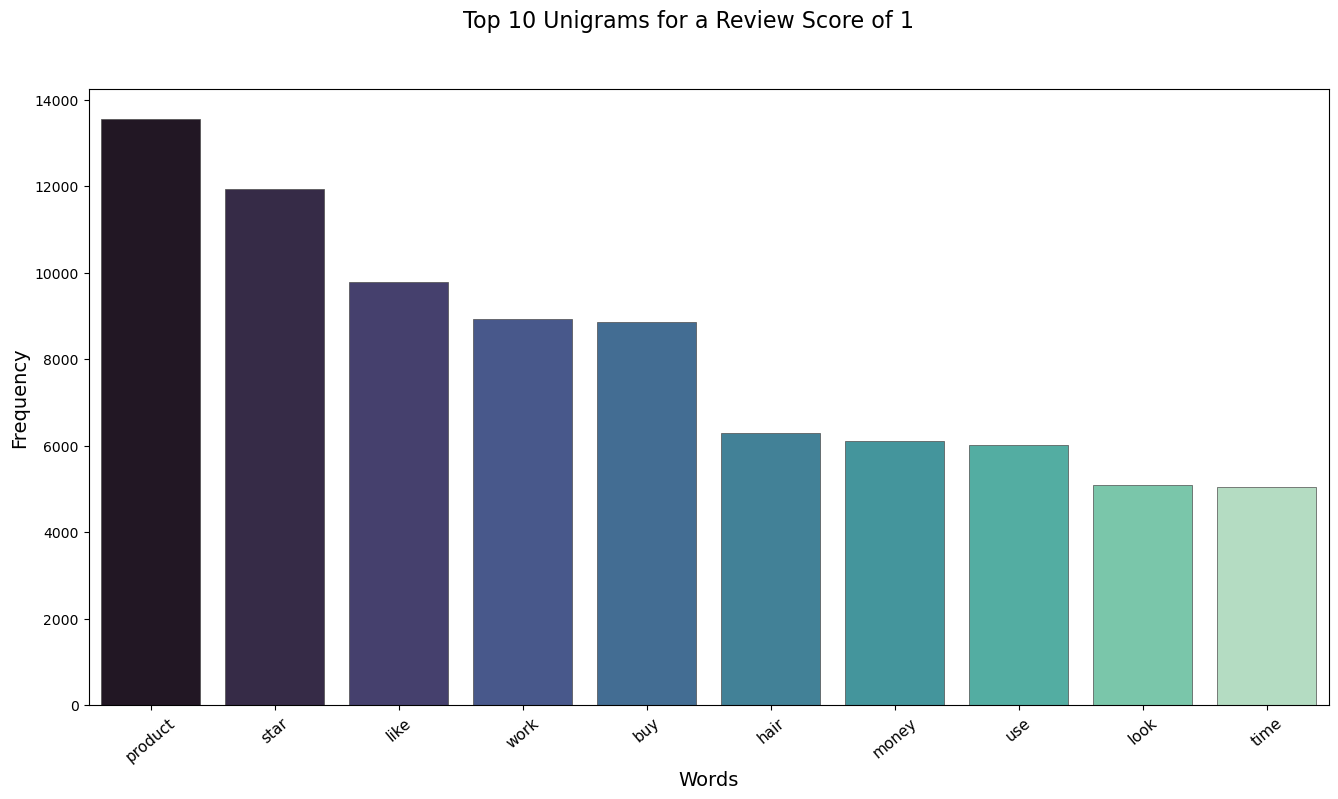

In [29]:
x, y = zip(*top_unigrams_1)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Unigrams for a Review Score of 1', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('../assets/eda/unigram_positive_top10.png')
plt.show()

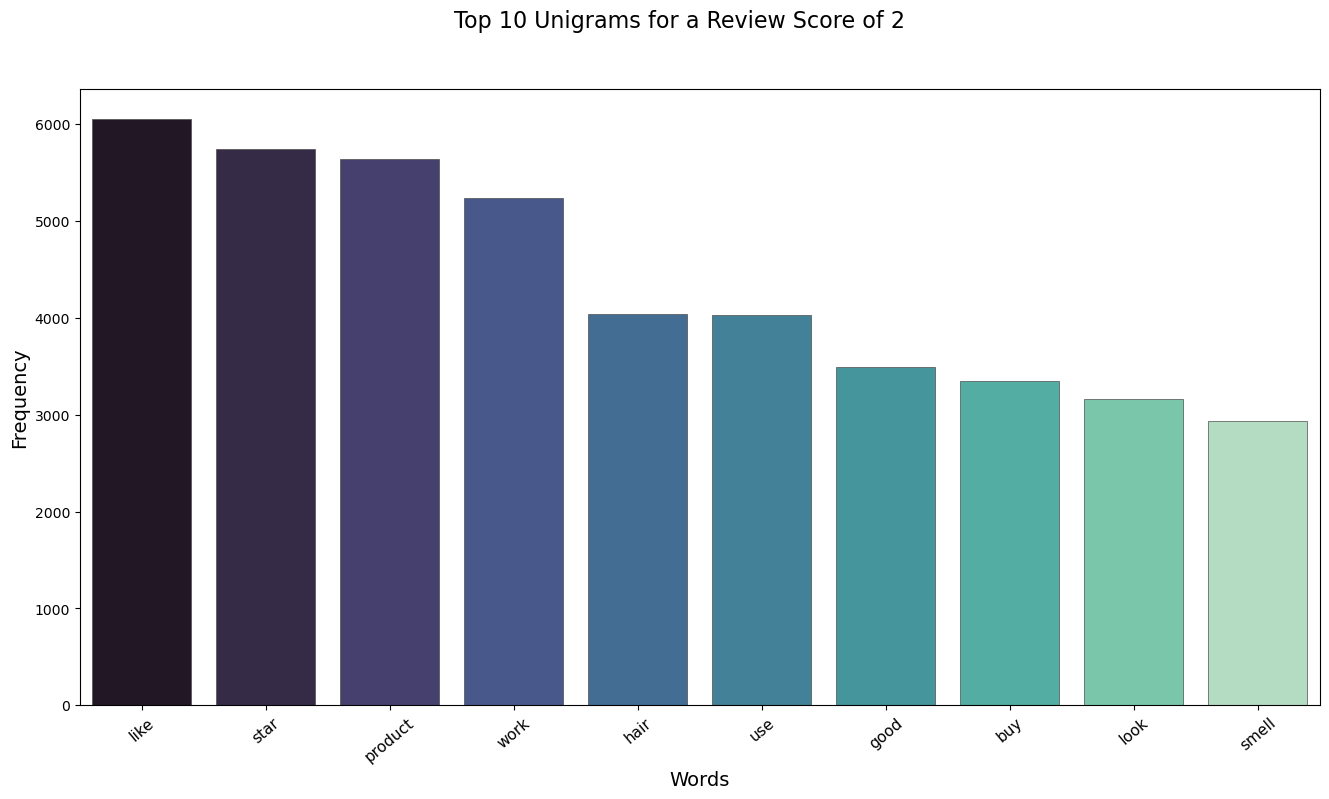

In [30]:
x, y = zip(*top_unigrams_2)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Unigrams for a Review Score of 2', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('../assets/eda/unigram_positive_top10.png')
plt.show()

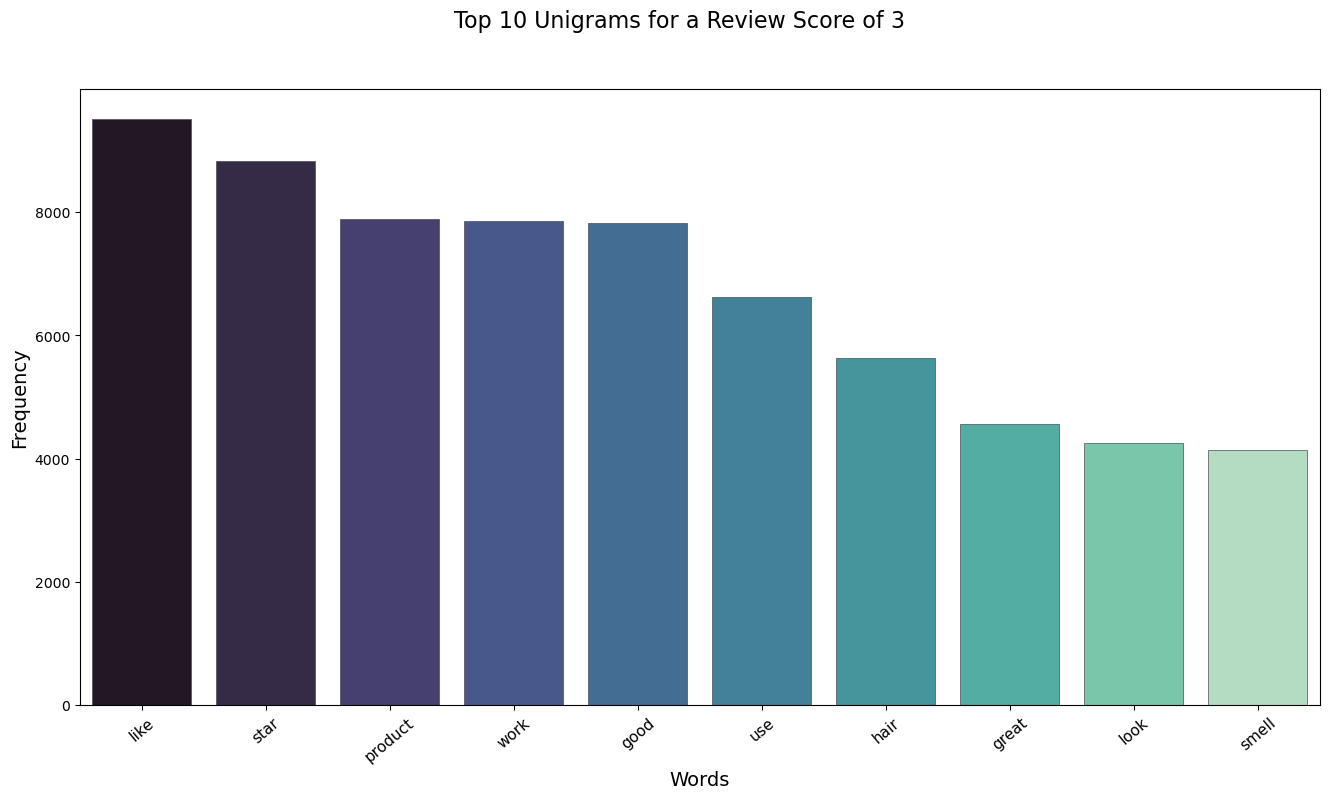

In [31]:
x, y = zip(*top_unigrams_3)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Unigrams for a Review Score of 3', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('../assets/eda/unigram_positive_top10.png')
plt.show()

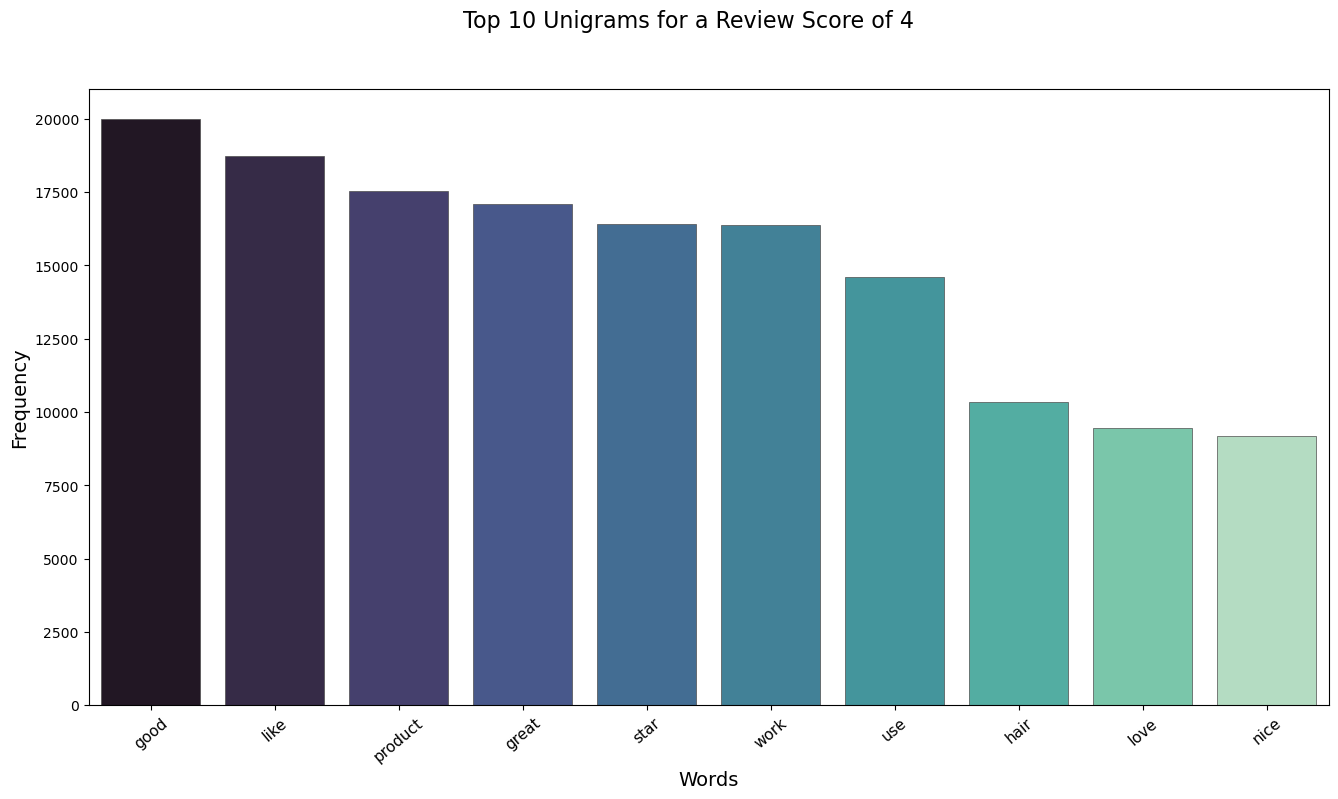

In [32]:
x, y = zip(*top_unigrams_4)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Unigrams for a Review Score of 4', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('../assets/eda/unigram_positive_top10.png')
plt.show()

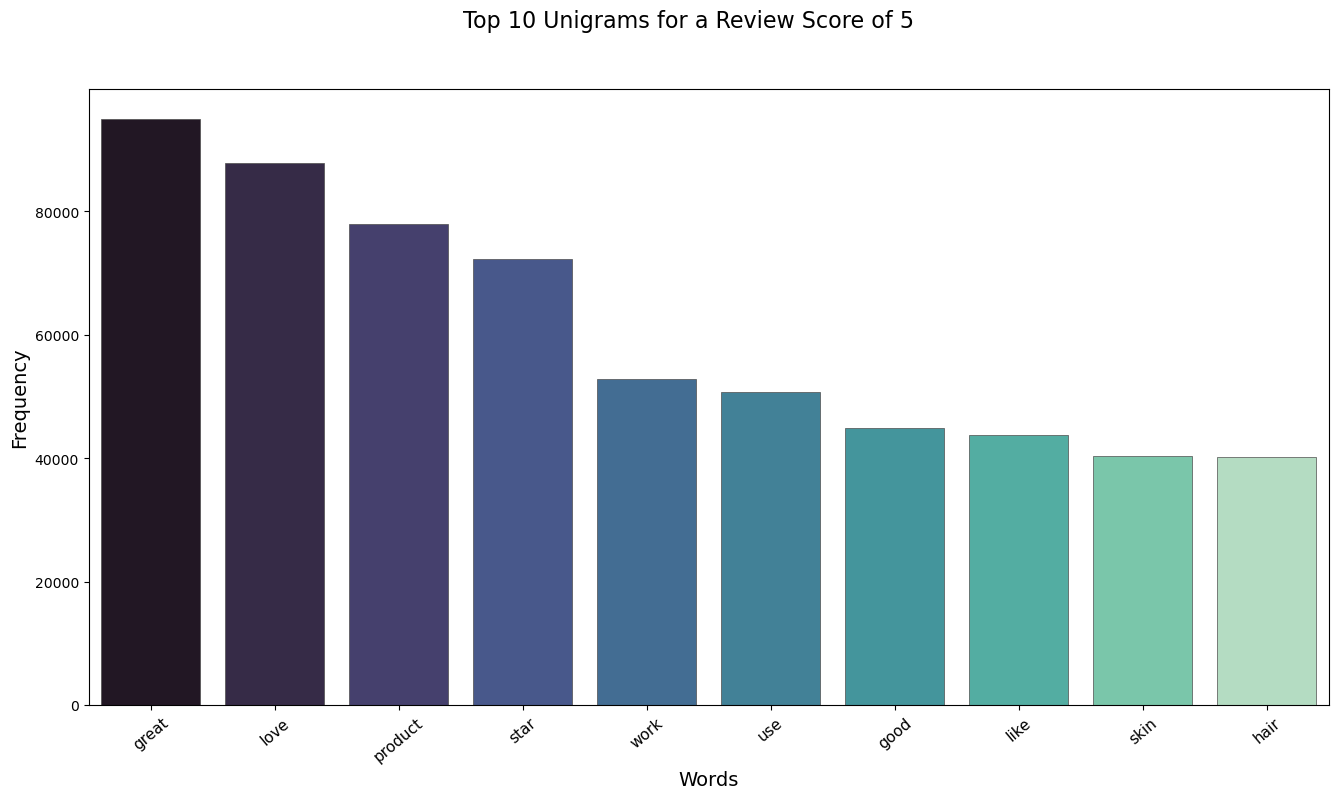

In [33]:
x, y = zip(*top_unigrams_5)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Unigrams for a Review Score of 5', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('../assets/eda/unigram_positive_top10.png')
plt.show()

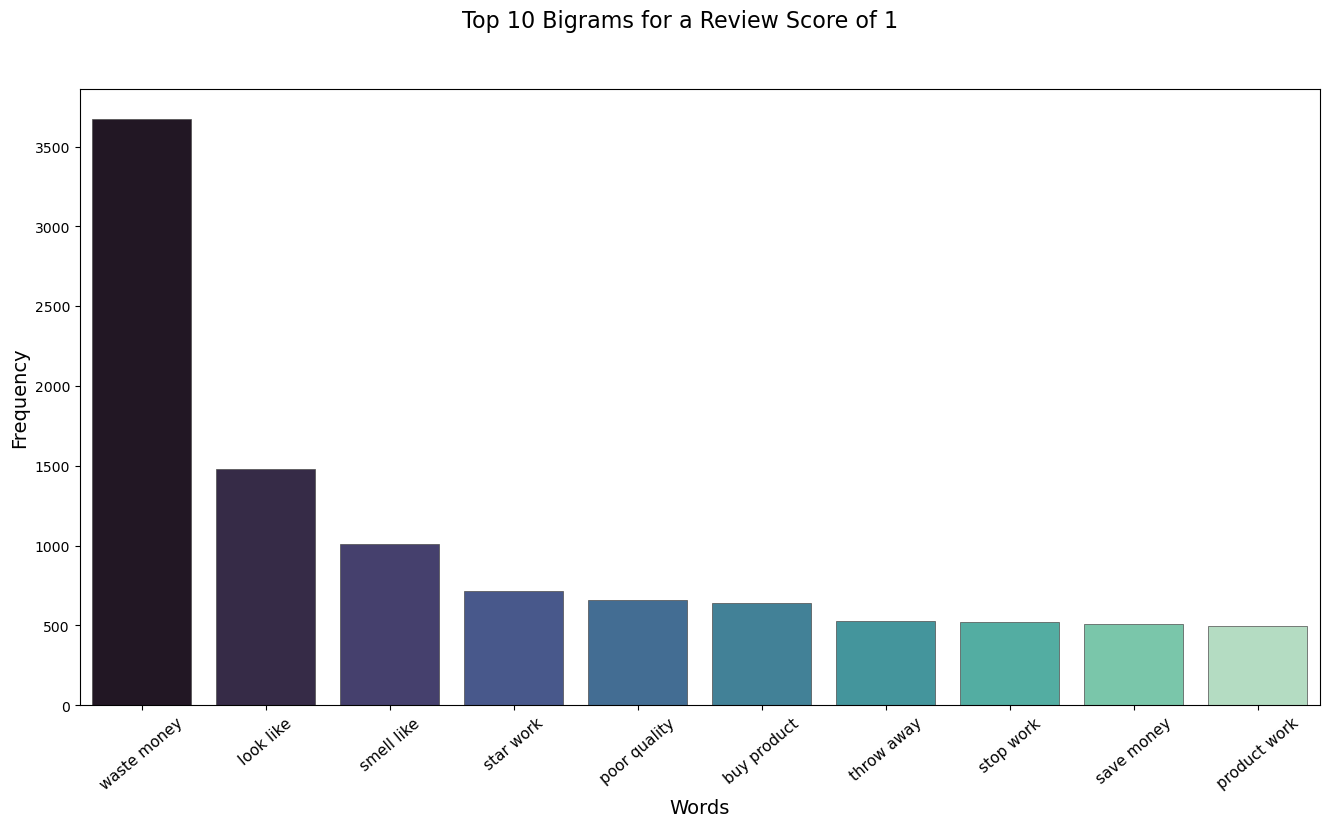

In [34]:
x, y = zip(*top_bigrams_1)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Bigrams for a Review Score of 1', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('top_bigram_1.png')
plt.show()

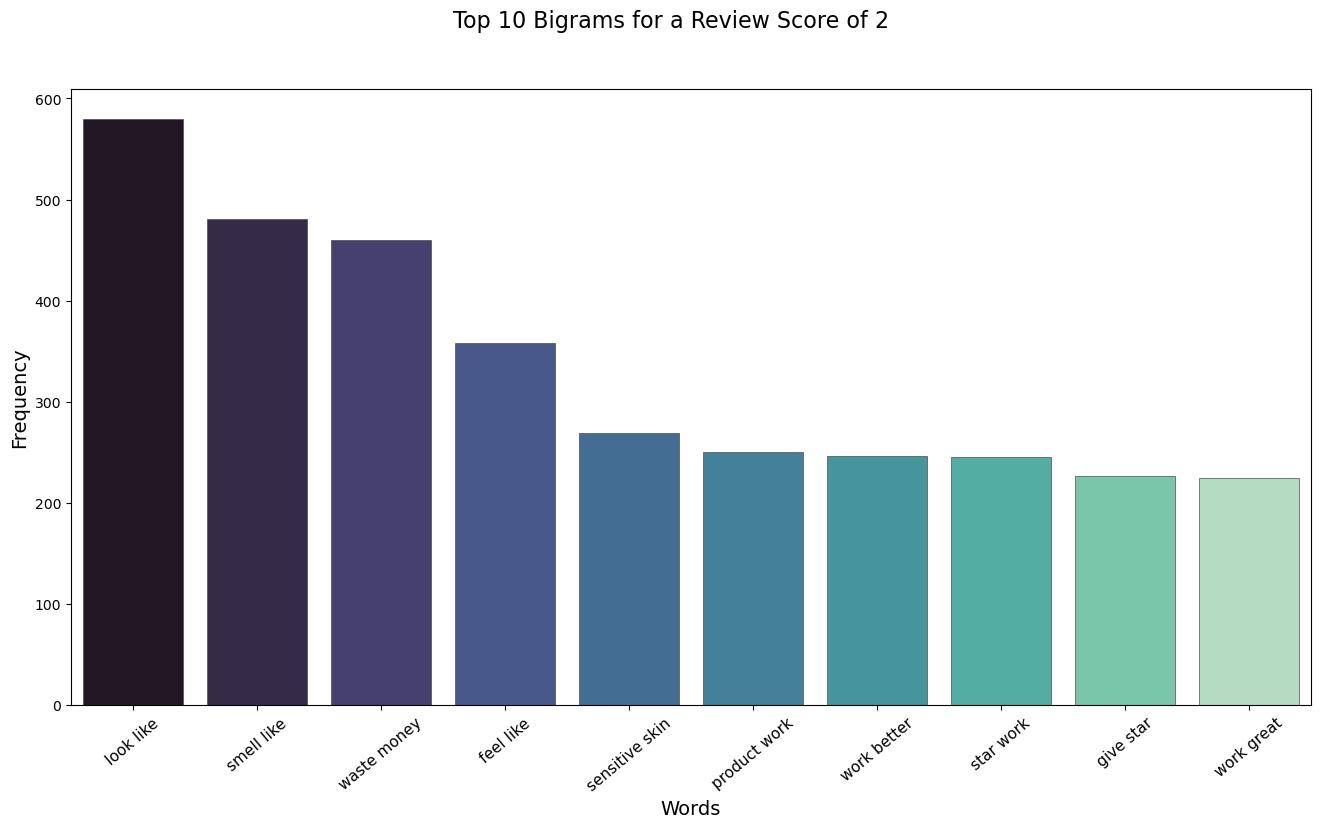

In [35]:
x, y = zip(*top_bigrams_2)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Bigrams for a Review Score of 2', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('top_bigram_2.png')
plt.show()

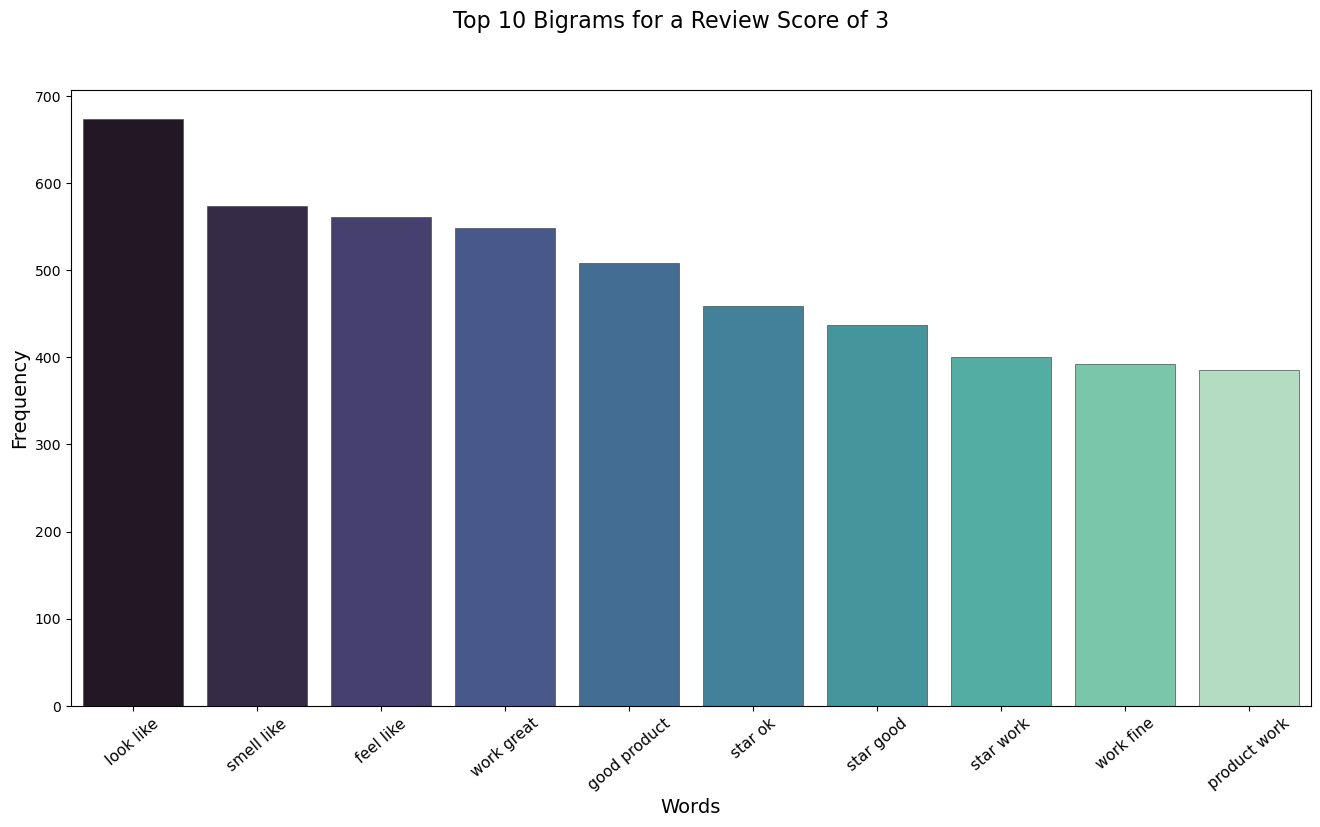

In [36]:
x, y = zip(*top_bigrams_3)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Bigrams for a Review Score of 3', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('top_bigram_3.png')
plt.show()

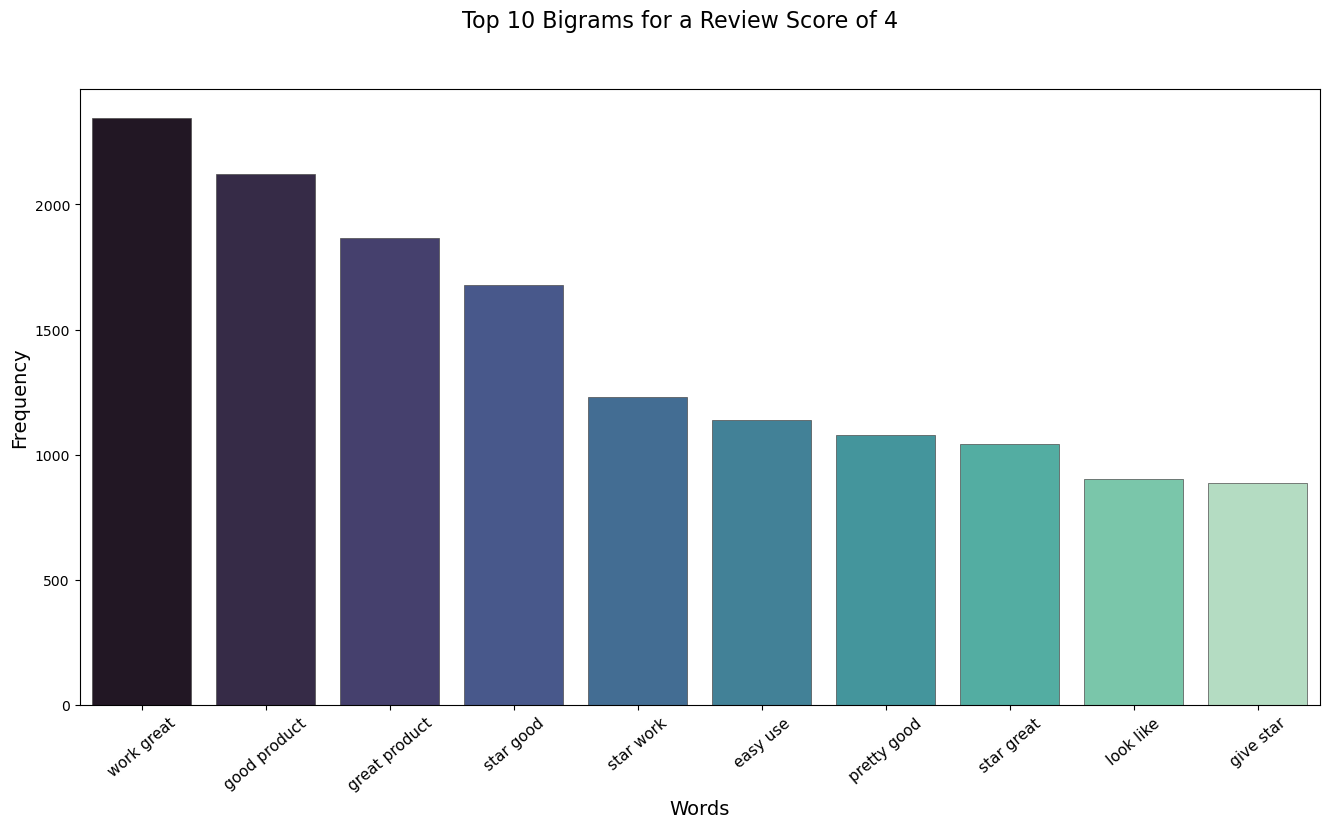

In [37]:
x, y = zip(*top_bigrams_4)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Bigrams for a Review Score of 4', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('top_bigram_4.png')
plt.show()

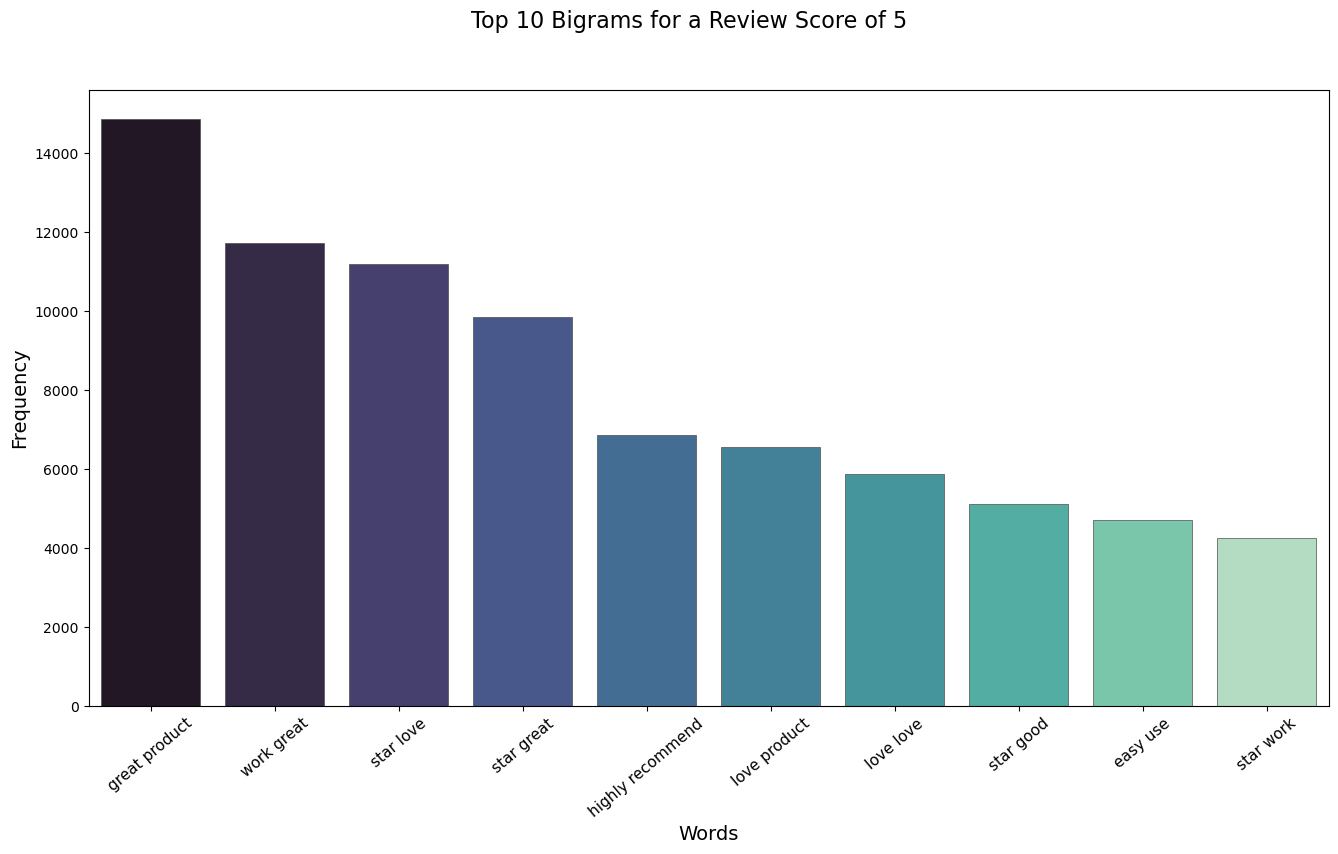

In [38]:
x, y = zip(*top_bigrams_5)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Bigrams for a Review Score of 5', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('top_bigram_5.png')
plt.show()

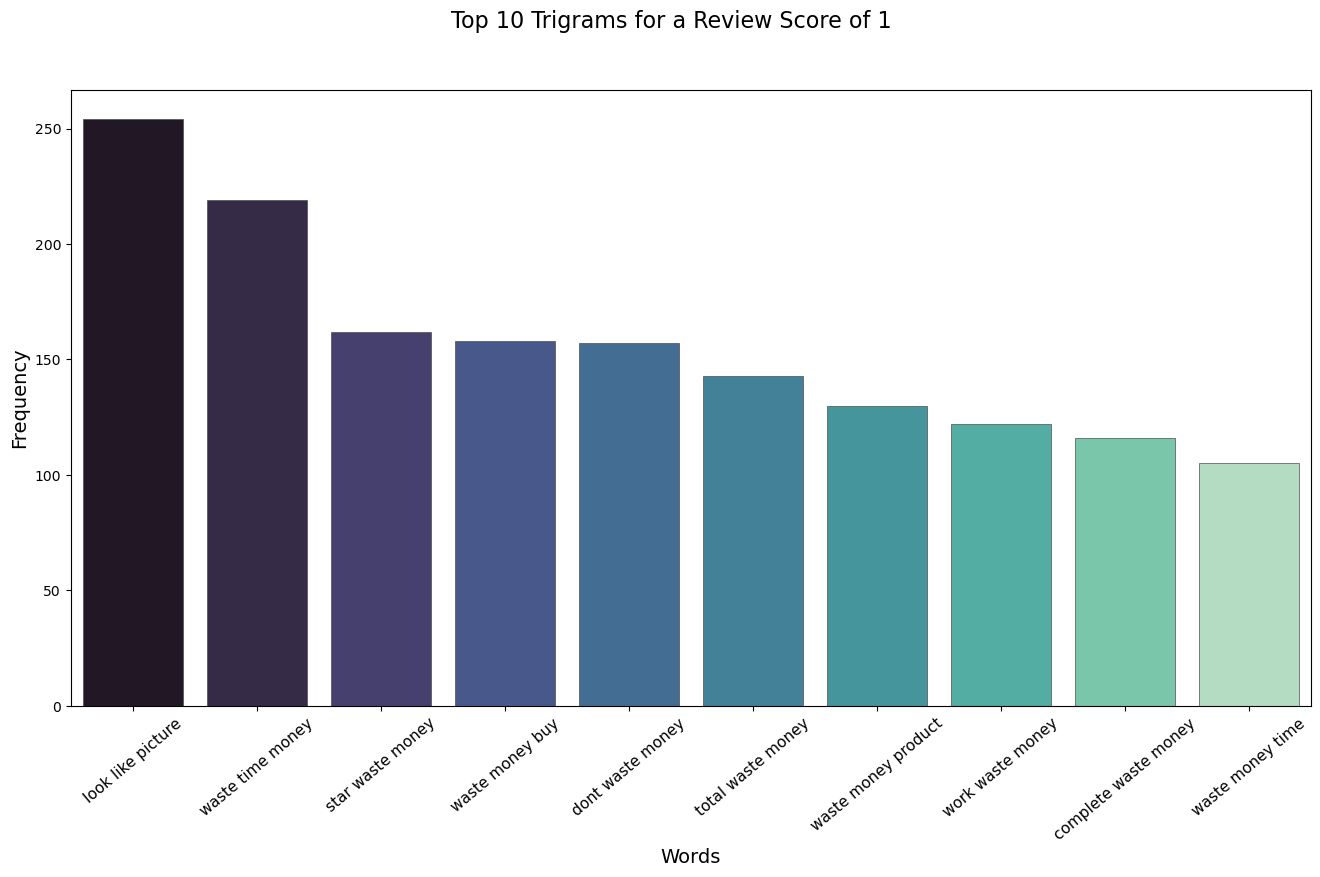

In [39]:
x, y = zip(*top_trigrams_1)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Trigrams for a Review Score of 1', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('top_trigram_1.png')
plt.show()

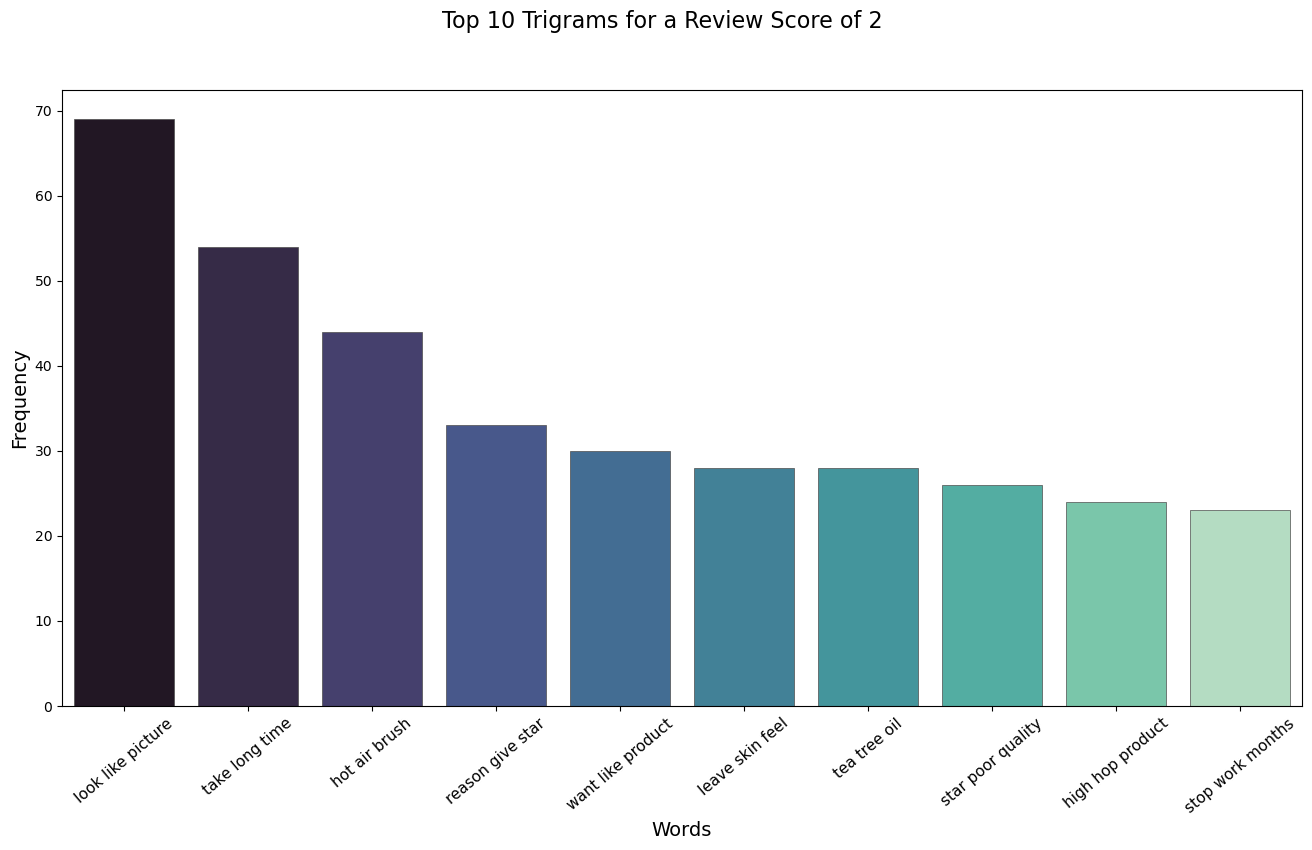

In [40]:
x, y = zip(*top_trigrams_2)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Trigrams for a Review Score of 2', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('top_trigram_2.png')
plt.show()

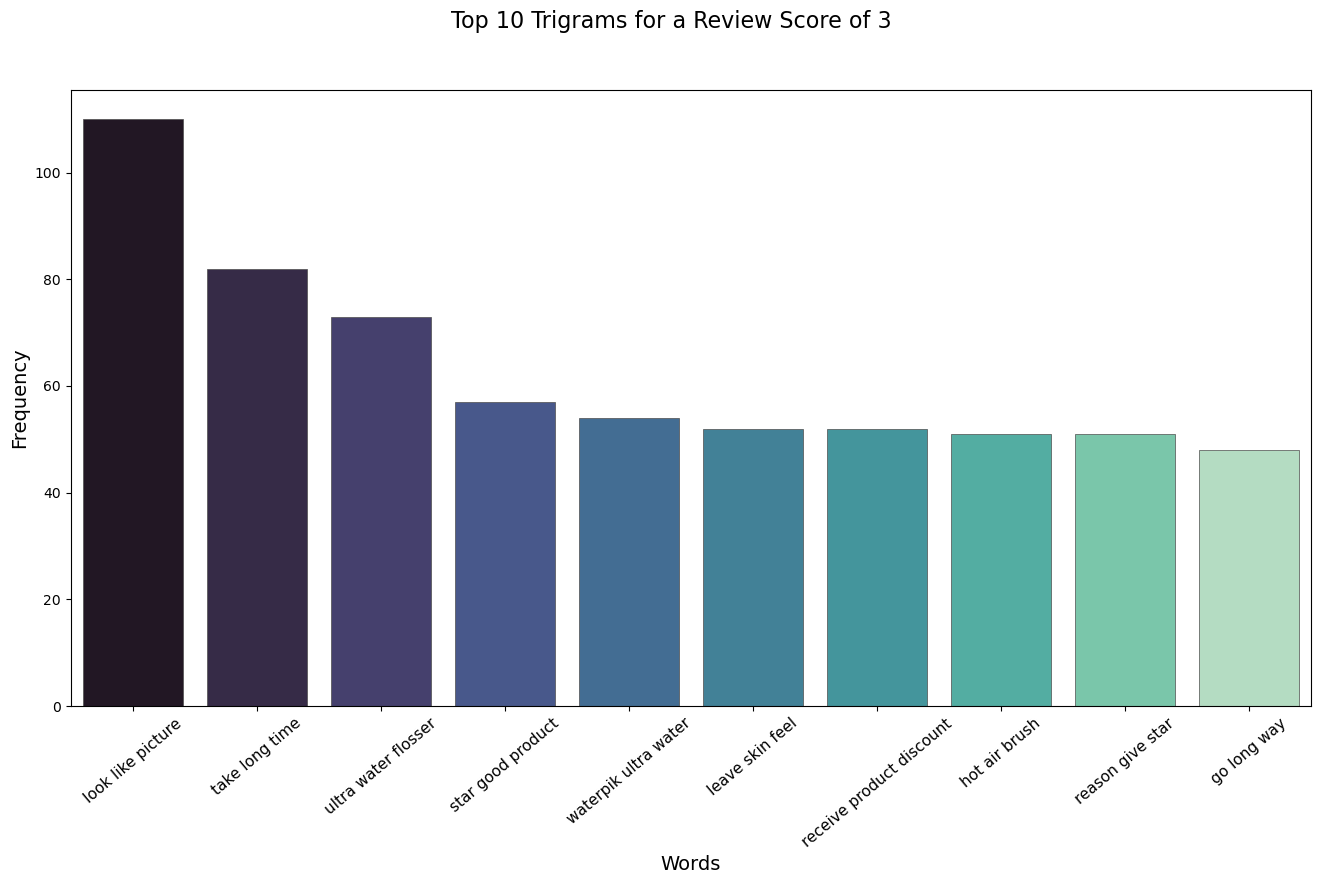

In [41]:
x, y = zip(*top_trigrams_3)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Trigrams for a Review Score of 3', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('top_trigram_3.png')
plt.show()

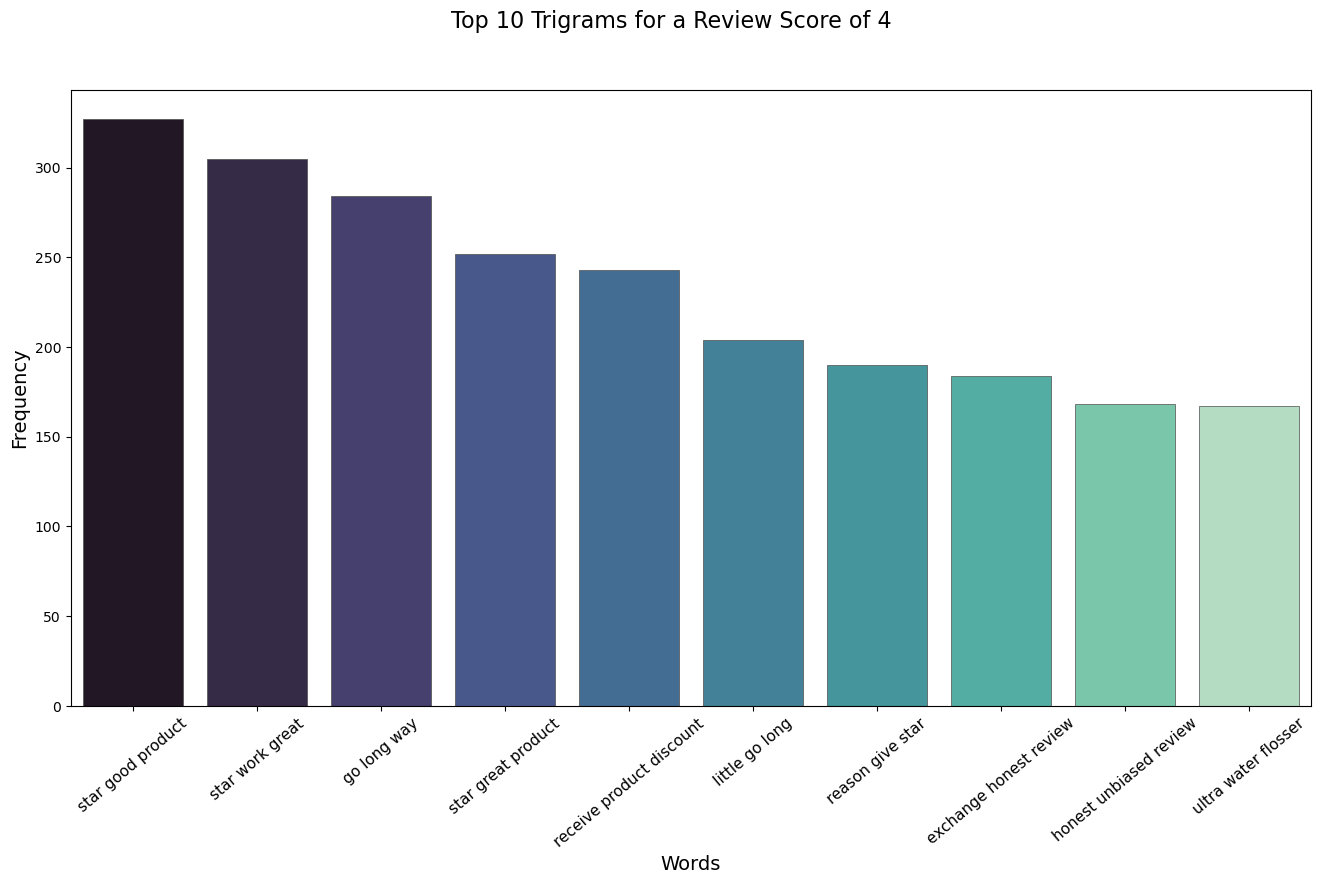

In [42]:
x, y = zip(*top_trigrams_4)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Trigrams for a Review Score of 4', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('top_trigram_4.png')
plt.show()

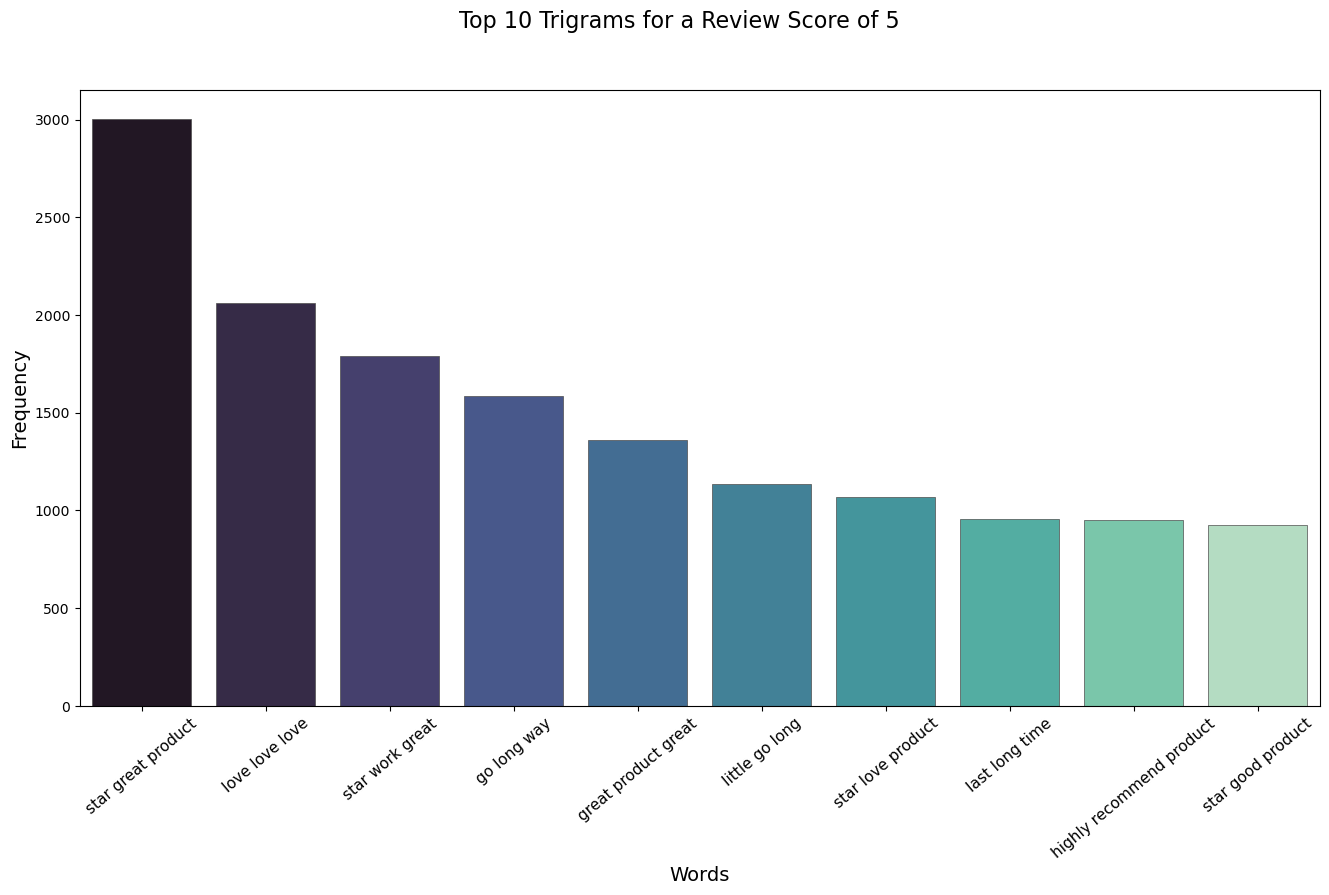

In [43]:
x, y = zip(*top_trigrams_5)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Trigrams for a Review Score of 5', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
# plt.savefig('top_trigram_5.png')
plt.show()

In [44]:
# save the feature engineered dataframe to a csv for model evaluation and selection
beauty_data_less.to_csv('../data/final/beauty_reviews_featurized.csv')